## Google timeline

NYU mhealth, March 2017, Avigail Vantu 

This notebook uses google timeline exported json one at a time and plot it eventually. 


In [1]:
import glob
#import fiona
import os
import json
from pandas import DataFrame
import pandas as pd
import geopandas as gpd
%matplotlib inline

import ast
import json
import urllib
import urllib2
from cStringIO import StringIO
#import mplleaflet
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from dateutil.parser import parse

import requests
import pandas as pd
from dateutil import parser, rrule
from datetime import datetime, time, date
import time

import pickle

In [2]:
from time import gmtime, strftime

In [3]:
from shapely.geometry import Point
from geopandas import GeoDataFrame

 read data

In [4]:
with open('LocationHistory.json') as json_data:
    d = json.load(json_data)
#  print(d)

## change format to geojson (geometry features) 

In [5]:

j = json.load(open("LocationHistory.json", "r"))
locs = j["locations"]
geoj= {"type":"FeatureCollection"}
geoj["features"] = []
for i in locs:
    feature = {"type":"Feature"}
    feature["geometry"] = {"type":"Point"}
    coords = []
    coords.append(float(i["longitudeE7"])/10000000)
    coords.append(float(i["latitudeE7"])/10000000)
    feature["geometry"]["coordinates"] = coords
# unix tine / 1000
    feature["properties"] = {"timestamp": float(i["timestampMs"])/1000}
    if i.has_key("activitys"):
        feature["properties"]["activitys"] = i["activitys"]
    feature["properties"]["accuracy"] = i["accuracy"]
    geoj["features"].append(feature)

f = open("loc.geojson","w")
f.write(json.dumps(geoj))
f.close()

"loc" is the geojson exported and that can be imported to CARTO 

In [6]:
geoj["features"][0]

{'geometry': {'coordinates': [-73.9941689, 40.7291516], 'type': 'Point'},
 'properties': {'accuracy': 10, 'timestamp': 1507555719.0},
 'type': 'Feature'}

In [7]:
geoj["features"][72]["geometry"]

{'coordinates': [-73.9747127, 40.6912949], 'type': 'Point'}

append the geojson into lists and then into dataframe 

In [8]:
list_p = []
for i in range(len(geoj["features"])):
    X = geoj["features"][i]["geometry"]["coordinates"]
    list_p.append(Point(X[0],X[1]))

## plot data

(4500000, 4520000)

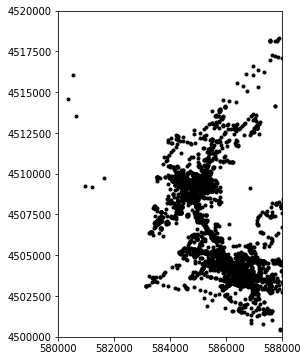

In [9]:
#print list_p
#for i in list_p:
#    print i
df = pd.DataFrame(list_p)
df["geometry"] = df[0]
del(df[0])
#df

crs = {'init': 'epsg:4326'}

# Set the coordinate reference system to WGS-84
#tobacco.crs = {'init' :'epsg:4326'}

# Project data to UTM zone 18N - i.e. flatten the earth.
#tobacco = tobacco.to_crs({'init': 'epsg:26918'})

#geometry = [Point(xy) for xy in zip(df.Lon, df.Lat)]
#df = df.drop(['Lon', 'Lat'], axis=1)
geo_df = GeoDataFrame(df, crs=crs)
geo_df = geo_df.to_crs({'init': 'epsg:26918'})

#geo_df

f, ax = plt.subplots(1,figsize = (4,6))
geo_df.plot(c='k',marker='.',ax=ax)
plt.xlim(580000,588000)
plt.ylim(4500000,4520000)

In [10]:
# Get NYC shapefile
nyc = gpd.read_file('NYC.geojson')
# project to utm 18
nyc = nyc.to_crs({'init': 'epsg:26918'})

f, ax = plt.subplots(1,figsize = (7,10))
plt.xlim(580000,588000)
plt.ylim(4500000,4520000)
nyc.plot(ax=ax,c='blue',facecolor='0.88')
geo_df.plot(ax=ax,c='k',marker='.')
plt.style.use('seaborn-dark-palette')

#plt.xlim([nyc.bounds['minx'].min(),nyc.bounds['maxx'].max()])
#plt.ylim([nyc.bounds['miny'].min(),nyc.bounds['maxy'].max()])

In [11]:
# create a new list for  
#[1] = lat [0] = lon 
lat = []
for i in range(len(geoj["features"])):
    X = geoj["features"][i]["geometry"]["coordinates"][1]
    lat.append(X)
    
lon = []
for i in range(len(geoj["features"])):
    X = geoj["features"][i]["geometry"]["coordinates"][0]
    lon.append(X)

In [12]:
len(geoj['features'])

11670

In [13]:
geoj['features'][0]

{'geometry': {'coordinates': [-73.9941689, 40.7291516], 'type': 'Point'},
 'properties': {'accuracy': 10, 'timestamp': 1507555719.0},
 'type': 'Feature'}

## Convert from linux time to timestamp 

In [14]:
## testing geojson to df:
# createa a list of the time stamp  - linux time
list_time = []
for i in range(len(geoj["features"])):
    Y = geoj["features"][i]["properties"]["timestamp"]
    list_time.append(Y)

#geoj["features"][1]["geometry"]["coordinates"]
#first 10 time stamps
list_time[:9]

[1507555719.0,
 1507555595.968,
 1507555451.255,
 1507555215.88,
 1507554844.688,
 1507554541.736,
 1507554141.0,
 1507554001.005,
 1507553888.967]

In [15]:
#convert daytime manualy, for each linux time int in the list apply lambda: convert to y
import datetime

#trying out lambds for linuxtime 
time = []
time = map(lambda x: (
    datetime.datetime.fromtimestamp(
        int(x)
    ).strftime('%Y-%m-%d %H:%M:%S')
) , list_time)



#sorted(time, reverse = True)
time[:10]

['2017-10-09 09:28:39',
 '2017-10-09 09:26:35',
 '2017-10-09 09:24:11',
 '2017-10-09 09:20:15',
 '2017-10-09 09:14:04',
 '2017-10-09 09:09:01',
 '2017-10-09 09:02:21',
 '2017-10-09 09:00:01',
 '2017-10-09 08:58:08',
 '2017-10-08 19:07:27']

## split the date into date only column -- date2

In [16]:
#list --> DataFrame
df1 = pd.DataFrame(time, columns=["date"])

# creating new column for 
df1['date2'] = df1['date'].apply(lambda x: x.split(' ')[0])
#df1[df1['date2'] == '2017-03-03']
#df1

In [17]:
#minimize inot only time of the day

df1['time'] = df1['date'].apply(lambda x: x.split(' ')[1])

#df1['date'][1:2]

In [18]:
#leave only hour
df1['time1'] = df1['time'].apply(lambda x: x.split(':'))
df1['time1'].head(2)

0    [09, 28, 39]
1    [09, 26, 35]
Name: time1, dtype: object

In [19]:
#df1['time2'] = df1['time1'].apply(lambda x: x.split(',')[-3])

In [20]:
df1['time1'][1]

['09', '26', '35']

In [21]:
#df1['time'] 09:28:39

In [22]:
# add the lon and lat to the df
df1['lon'] = lon
df1['lat'] = lat
df1.head(1)

,date,date2,time,time1,lon,lat
0,2017-10-09 09:28:39,2017-10-09,09:28:39,"[09, 28, 39]",-73.994169,40.729152


In [23]:
len(df1)

11670

In [24]:
# unique values for days

p = df1.date2.unique()
# unique dates from array to list 
p_list = p.tolist()
#p_list

In [25]:
print df1.dtypes

date      object
date2     object
time      object
time1     object
lon      float64
lat      float64
dtype: object


In [26]:
#df1('date').isoweekday () in range(1, 6)
#df1['day_of_week'] = df1['date'].apply(lambda x: x.weekday())

In [27]:
#appending the parsed date into a list 
day_of_week = []
for i in range(len(df1)):
    d = parse(df1.date[i])
    day_of_week.append(d)
    
# apply weekday function to the parsed date column     
weekday = []    
for i in range(len(day_of_week)):
    g = day_of_week[i].weekday()
    weekday.append(g)

print day_of_week[:5]
print weekday[:5]

[datetime.datetime(2017, 10, 9, 9, 28, 39), datetime.datetime(2017, 10, 9, 9, 26, 35), datetime.datetime(2017, 10, 9, 9, 24, 11), datetime.datetime(2017, 10, 9, 9, 20, 15), datetime.datetime(2017, 10, 9, 9, 14, 4)]
[0, 0, 0, 0, 0]


## sparse to add day of the week and weekdne/ weekday 


daytime sparser: 0= monday, 1=tuesdya 2=wed, 3=thursday, 4=friday, 5=sat , 6= sunday 

In [28]:
#add weekday # into the df1

#daytime sparser: 0= monday, 1=tuesdya 2=wed, 3=thursday, 4=friday, 5=sat , 6= sunday 
df1['weekday'] = weekday


In [29]:
# create new binaric column for weekday (1) / weekend (0)

df1['workday'] = df1.apply(lambda row: "1" if row['weekday'] < 5 else "0", axis=1)
df1.head(20)

#df1[df1['weekday']==3]

,date,date2,time,time1,lon,lat,weekday,workday
0,2017-10-09 09:28:39,2017-10-09,09:28:39,"[09, 28, 39]",-73.994169,40.729152,0,1
1,2017-10-09 09:26:35,2017-10-09,09:26:35,"[09, 26, 35]",-73.993865,40.729172,0,1
2,2017-10-09 09:24:11,2017-10-09,09:24:11,"[09, 24, 11]",-73.995774,40.726589,0,1
3,2017-10-09 09:20:15,2017-10-09,09:20:15,"[09, 20, 15]",-73.994261,40.727734,0,1
4,2017-10-09 09:14:04,2017-10-09,09:14:04,"[09, 14, 04]",-73.988392,40.703564,0,1
5,2017-10-09 09:09:01,2017-10-09,09:09:01,"[09, 09, 01]",-73.985317,40.691576,0,1
6,2017-10-09 09:02:21,2017-10-09,09:02:21,"[09, 02, 21]",-73.976321,40.683191,0,1
7,2017-10-09 09:00:01,2017-10-09,09:00:01,"[09, 00, 01]",-73.976800,40.681629,0,1
8,2017-10-09 08:58:08,2017-10-09,08:58:08,"[08, 58, 08]",-73.977585,40.680441,0,1
9,2017-10-08 19:07:27,2017-10-08,19:07:27,"[19, 07, 27]",-73.977666,40.680490,6,0


In [31]:
#bins = [09:00:00,]
#df1[df1['time']<'09:00:00'and df1['time']>'18:00:00']

In [32]:
#len(df1['date'].between('2017-10-01 23:46:41', '2017-10-01 11:51:05', inclusive=True))


In [33]:
df1[df1['weekday']==6].head()

,date,date2,time,time1,lon,lat,weekday,workday
9,2017-10-08 19:07:27,2017-10-08,19:07:27,"[19, 07, 27]",-73.977666,40.680490,6,0
10,2017-10-08 19:04:32,2017-10-08,19:04:32,"[19, 04, 32]",-73.977551,40.680388,6,0
11,2017-10-08 19:02:14,2017-10-08,19:02:14,"[19, 02, 14]",-73.977706,40.680469,6,0
12,2017-10-08 19:02:11,2017-10-08,19:02:11,"[19, 02, 11]",-73.977620,40.680436,6,0
13,2017-10-08 18:59:25,2017-10-08,18:59:25,"[18, 59, 25]",-73.978562,40.679281,6,0


In [34]:
#create another dataframe with points insted of lat lon, for carto

df2 = pd.DataFrame(list_p, columns=["point"])
df2['date'] = df1['date']
df2['workday'] = df1['workday']
df2['weekday'] = df1['weekday']
df2.head(2)

,point,date,workday,weekday
0,POINT (-73.99416890000001 40.7291516),2017-10-09 09:28:39,1,0
1,POINT (-73.9938648 40.7291716),2017-10-09 09:26:35,1,0


## export to CSV

export DF to csv

In [35]:
#export the df
df1.to_csv('google_t_avigail.csv')
df2.to_csv('google_t_avigail1.csv')

In [36]:
strftime("%a, %d %b %Y %H:%M:%S +0000",gmtime())

'Mon, 27 Nov 2017 19:43:15 +0000'

create new geo data frame to export to CARTO: 

In [37]:
dfgeo = GeoDataFrame(df, crs=crs)

In [38]:
#add columns to make it intresting!
dfgeo['date'] = df1['date']
dfgeo['workday'] = df1['workday']
dfgeo['weekday'] = df1['weekday']

In [39]:
# export the geo for carto carto 
dfgeo.to_csv('google_t_geodf.csv')

In [40]:
dfgeo['workday'][50:55]

50    0
51    0
52    0
53    0
54    0
Name: workday, dtype: object

NTA's

#adding the NTA's geojson
map_DCP = []
with open('Neighborhood Tabulation Areas.geojson', 'r') as f:
    map_DCP = json.load(f)


fig = plt.figure(figsize=(26,20))
plt.xlim(-74.5,-73.65)
plt.ylim(40.5,40.95)
for a in range (len(map_DCP['features'])):
    coords = map_DCP['features'][a]['geometry']['coordinates'][0]
    x = [i for i,j in coords[0]]
    y = [j for i,j in coords[0]]
    ax = fig.gca() 
    ax.plot(x,y, c='black', lw=2)
geo_df.plot(ax=ax,c='k',marker='.')

In [46]:
from geopy.distance import vincenty

# distance measurment

In [47]:
#testing the distance measurmant first

point1 = (df1.lon[1], df1.lat[1])
point2 = (df1.lon[2], df1.lat[2])
print"1",(vincenty(point1, point2).miles) 

point3 = (-73.993865, 40.729172)
point4 = (-73.995774, 40.726589)
print"2",(vincenty(point3, point4).miles) 
#It works!
#the small diffrence b/w both measurments is due to decimels 

1 0.141346338973
2 0.14131136798


In [48]:
df1.head(3)

,date,date2,time,time1,lon,lat,weekday,workday
0,2017-10-09 09:28:39,2017-10-09,09:28:39,"[09, 28, 39]",-73.994169,40.729152,0,1
1,2017-10-09 09:26:35,2017-10-09,09:26:35,"[09, 26, 35]",-73.993865,40.729172,0,1
2,2017-10-09 09:24:11,2017-10-09,09:24:11,"[09, 24, 11]",-73.995774,40.726589,0,1


In [51]:
dis

[0,
 0.02109283968750707,
 0.14134633897289162,
 0.10723559460102039,
 0.6160903808588986,
 0.3132520996397803,
 0.6441905223216806,
 0.044714473946829515,
 0.05898800517796434,
 0.005675310070109016,
 0.00821236936441932,
 0.01089383950637216,
 0.006024677432180937,
 0.06902208291050033,
 0.0007670784992394444,
 0.0005482530789916513,
 0.003080514392113913,
 0.09674568953869464,
 0.007604264984632094,
 0.005955296023706218,
 0.02144346276042774,
 0.055549765507498156,
 0.08203633284560546,
 0.14910629165778505,
 0.04397741346339103,
 0.05271980953365733,
 0.021156431208130343,
 0.008089936221497672,
 0.2077083580084136,
 0.05797723755212852,
 0.05352260077771626,
 0.14784863090936134,
 0.048852359420783996,
 0.06713216946399374,
 0.012335742221791379,
 0.00400161248915538,
 0.19613484763481168,
 0.0064594876020937384,
 0.012567399793936156,
 0.1869589661044836,
 0.03171187761378758,
 0.039149211660114674,
 0.0013010989239910877,
 0.001730324175753079,
 0.05604475355462559,
 0.09882287

In [50]:
#now trying to append the distance 
#create a dictionary and add 0 to the first value  
dis = [0,]
for i in range(len(df1.lon)):
    point1 = (df1.lon[i], df1.lat[i])
    point2 = (df1.lon[i+ 1], df1.lat[i+ 1])
    r = (vincenty(point1, point2).miles)
    
    dis.append(r)
    
    
  

KeyError: 11670

In [63]:
#ingore error in the previuos cell

### dis is the list of distance b/w two tied points measured in miles


In [52]:
dis[:3]
#len(df1)

[0, 0.02109283968750707, 0.14134633897289162]

aggragate distance
1. by day

In [95]:
len(df1[df1['date2'] == '2017-03-02' ])
#print df1['date2'].min()

63

## group by date, how many data points per day

In [91]:
df2 = df1.groupby('date2')['date'].nunique()

In [96]:
df2.head()

date2
2017-03-01    17
2017-03-02    63
2017-03-03    35
2017-03-04    63
2017-03-05    13
Name: date, dtype: int64

## plot data points per day

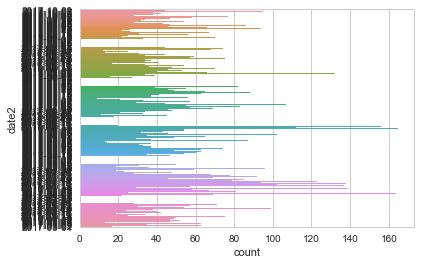

In [98]:
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

sns.countplot(y="date2", data=df1)
plt.show()

In [102]:
#how many workdays and how many weeknd data points

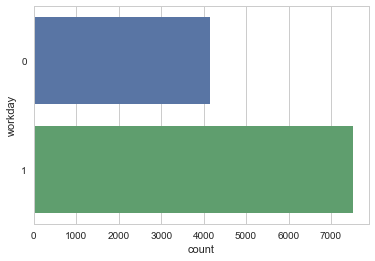

In [101]:
sns.countplot(y="workday", data=df1)
plt.show()

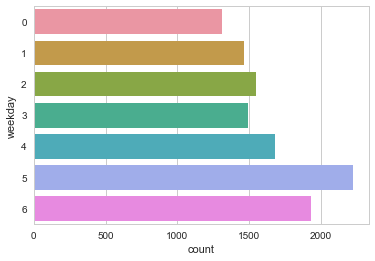

In [104]:
#how man data points per day of the week
#0= monday, 1=tuesday 2=wed, 3=thursday, 4=friday, 5=sat , 6= sunday

sns.countplot(y="weekday", data=df1)
plt.show()

In [53]:

df1['distance'] = dis

In [54]:
df1.head()

,date,date2,time,time1,lon,lat,weekday,workday,distance
0,2017-10-09 09:28:39,2017-10-09,09:28:39,"[09, 28, 39]",-73.994169,40.729152,0,1,0.000000
1,2017-10-09 09:26:35,2017-10-09,09:26:35,"[09, 26, 35]",-73.993865,40.729172,0,1,0.021093
2,2017-10-09 09:24:11,2017-10-09,09:24:11,"[09, 24, 11]",-73.995774,40.726589,0,1,0.141346
3,2017-10-09 09:20:15,2017-10-09,09:20:15,"[09, 20, 15]",-73.994261,40.727734,0,1,0.107236
4,2017-10-09 09:14:04,2017-10-09,09:14:04,"[09, 14, 04]",-73.988392,40.703564,0,1,0.616090


## aggragate distance number by day

In [55]:
# each row is one day - distance is total distance traveled this day 
dis_day = df1.groupby('date2').sum()
print dis_day.head()

                    lon          lat  weekday   distance
date2                                                   
2017-03-01 -1257.793114   692.013807       34   2.422242
2017-03-02 -4661.370800  2565.034743      189   9.266556
2017-03-03 -2589.636052  1425.426485      140   4.818904
2017-03-04 -4661.196477  2564.222065      315  10.720563
2017-03-05  -961.707277   528.850521       78   0.379363


In [56]:
len(dis_day)

223

In [57]:
#maximun distance travled
print "max", dis_day.distance.max()
print "min", dis_day.distance.min()

max 7572.4430313
min 0.379363339116


In [58]:
#find those observations:  
print "max date", dis_day[dis_day['distance'] == 7572.4430313033154]
print "min date", dis_day[dis_day['distance'] == 0.379363339116]

max date                     lon          lat  weekday     distance
date2                                                     
2017-04-15  3282.180458  3013.638818      470  7572.443031
min date Empty DataFrame
Columns: [lon, lat, weekday, distance]
Index: []


In [59]:
dis_day = dis_day.sort_values(['distance'], ascending=[True])

In [60]:
#the five days most distnace
dis_day[218:223]


,lon,lat,weekday,distance
date2,,,,
2017-08-30,319.706725,3667.232903,148,826.357358
2017-09-05,-1676.329013,3979.552129,84,6041.316926
2017-08-29,-5026.209817,2766.164660,68,6044.864125
2017-04-01,-4359.779997,2399.309693,295,7514.971033
2017-04-15,3282.180458,3013.638818,470,7572.443031


In [61]:
#the five days least distnace
dis_day[:5]

,lon,lat,weekday,distance
date2,,,,
2017-03-05,-961.707277,528.850521,78,0.379363
2017-06-24,-813.744471,447.484287,55,0.449527
2017-04-10,1018.304142,932.296790,0,0.711925
2017-03-12,-1849.427907,1017.034198,150,0.946742
2017-08-02,-1183.620566,650.845830,32,0.975789
